# Data Version Control For the Modern Data Scientist: 7 DVC Concepts You Can't Ignore
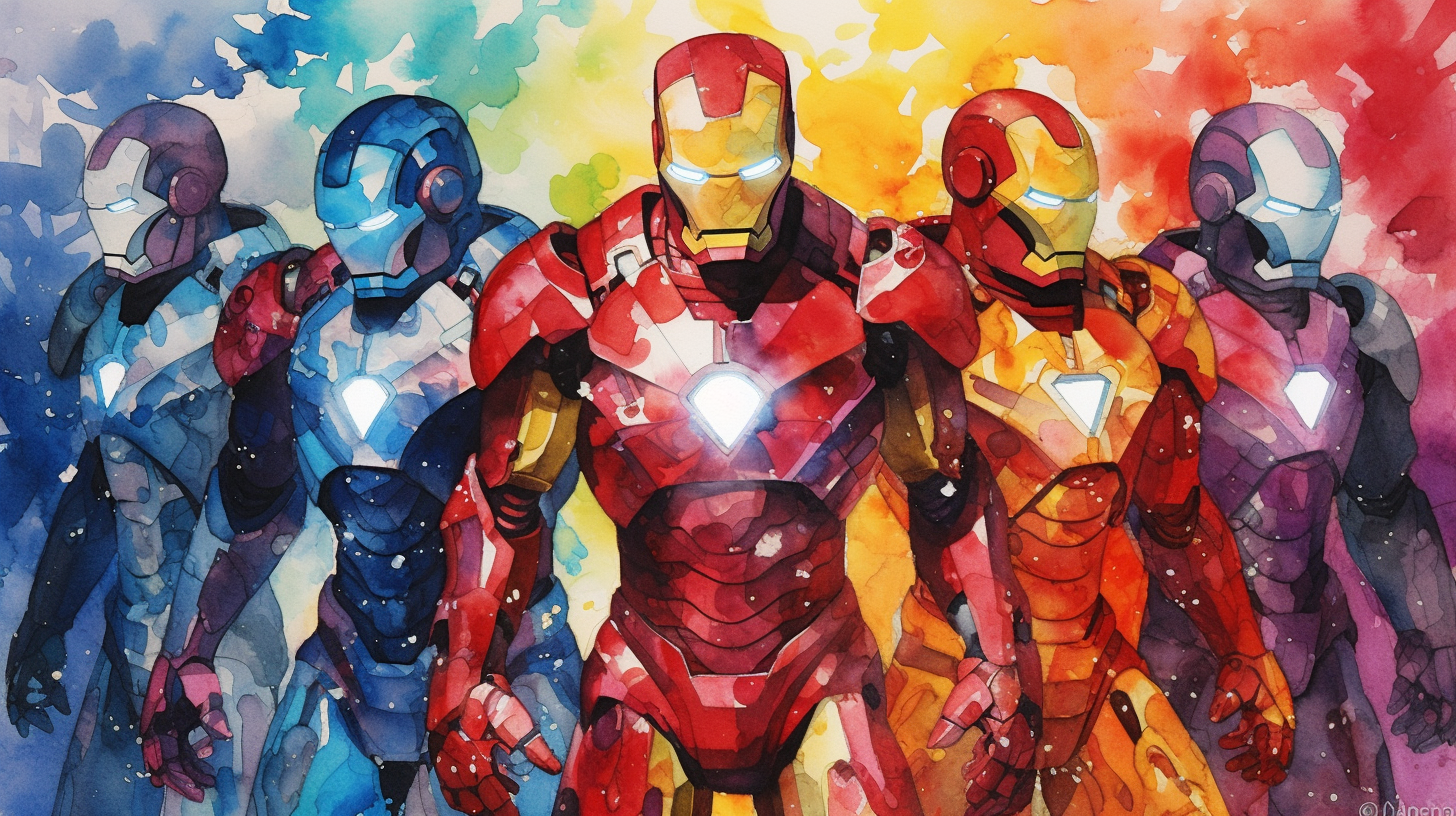

# May 31, 2020

What a beautiful day! There I was, listening to **Data Beats FM** in my car when this advertisement caught my attention.

> Data scientists have envied software engineers for a loooong time. While pure software engineers, let's playfully call them evil programming wizards, glide through code commits and branches with trusty Git, we often find ourselves grappling with monstrous datasets and ML models that leave Git gasping for air. But fear not, there comes DVC in shining armor...

I cranked up the volume, with a curious expression on my face.

> DVC, with its exceptional capabilities, is here to liberate tens of thousands of data scientists from the clutches of Git's struggle with managing those massive files that seem to defy every attempt at efficient versioning (Git-LFS just plain sucked).

I was smiling at this point.

> It is time to bid adieu to the days of frantically deleting and re-uploading data to avoid Git's size limitations. With DVC, we can finally reclaim our sanity and confidently march forward in our data-driven endeavors.

You could've counted all my teeth.

> Check it out for free at...

I got into a tunnel and lost the signal. Almost swearing with joy, I pulled over as soon as the tunnel ended and pulled out the traveling MacBook. I punched DVC into the search bar and...

--------------------

This was taken from an imaginary data scientist's imaginary diary. The entry goes on for a while, raving about the delights of data version control with DVC and how it skillfully fixes the Git-sucking-at-large-files problem.

I decided to skip that part and show the rest, where our imaginary friend explains eight of the most important DVC concepts that no self-respecting data scientist can afford to ignore. I have to say, the explanations are wonderful :)

Let's read on.


### 0. DVC as a version control system

DVC is not a version control system when you get into it. Instead, it mimics Git's functionality for large files while operating as a metadata management tool that runs alongside Git. 

Rather than directly attacking massive datasets and ML models (large assets), DVC generates metadata file placeholders for them. These lightweight files allow for pseudo-tracking of the assets when you begin tracking them with Git.

For instance, let's say you've just written a script to apply image augmentation, thereby increasing the number of samples in your image dataset. As DVC has created a metadata file placeholder for the folder containing your images, it promptly detects the operation and updates the metadata file accordingly. Subsequently, since Git was tracking that metadata file, it also recognizes the change.

In this way, modifications to large files can become part of your Git commits and history without causing Git to crash and burn.

### 1. Tracked and untracked files

When initializing DVC within a Git-tracked repository, the files can be categorized into three categories.

Category 0 comprises files that are solely tracked by Git using the `git add filename` command. DVC has nothing to do with them. Typically, they include source code files (`.py`, `.jl`, `.R`, etc.), configuration files (`.ini`, `.cfg`, `.yaml`, `.json`), documentation files (Markdown, READMEs, and other text formats), or test files.

Category 1 encompasses files listed in the `.gitignore` file. These are the ones that are never, ever tracked by Git.

In category 2, we have DVC-tracked files, which are the results of using `dvc add asset` commands. 

As an example, let's consider a model file named `tuned.joblib` and an image dataset stored within the `images` folder. Once you execute `dvc add images tuned.joblib`, both the file and the folder are placed under DVC-watch and added to the `.gitignore` file, preventing accidental Git tracking. 

Additionally, two new files with the `.dvc` extension will be generated: `images.dvc` and `tuned.joblib.dvc`. 

These lightweight metadata files fall under category 0, which means you should track them with Git using the command `git add images.dvc tuned.joblib.dvc`. 

Typical files found in category 2 include notebooks (which may contain visuals and tables, potentially resulting in large sizes), datasets (such as images, videos, audios, CSVs, parquets, databases, etc.), and ML models.

Lastly, in category 3, we have the optional `.dvcignore` files. Similar to .gitignore files, you can use them to specify files that DVC should never track.

### 2. `.dvc` files

`.dvc` files use [the YAML 1.2](https://yaml.org/) file format, which is a human-friendly data serialization format for all programming languages. 

When you take a peek inside the contents of `images.dvc`, you will see the following entries:

```
- md5: 7157b07ef86df5cb0197886cf918f8ab.dir
    size: 41224
    nfiles: 253
    path: images
```


The most interesting part is `md5`. MD5 is a popular hashing function. It takes a file of arbitrary size and uses its contents to produce a string of characters of fixed length (32 characters in our case). 

These characters can seem random, but they will always be the same if you rerun the hashing function on the file however many times. But, even if a single bit is changed in the file, the resulting hash will be completely different. 

DVC uses these hashes (also called checksums) to differentiate whether two files are identical, completely different, or different versions of the same file.

For example, if I add a new fake image to the `images` folder, the resulting MD5 hash inside `images.dvc` will be different:

```
- md5: 64ae4591a5ca0bf07459904bc7c2d126.dir
    size: 42532
    nfiles: 254
    path: images
```

As mentioned earlier, you should track all `.dvc` files with Git.

```
$ git add images.dvc
```

### 3. DVC cache

When you call `dvc add` on a large asset, it gets copied into a special directory called DVC cache, located under `.dvc/cache`.

The cache is the place where DVC keeps a pristine record of your data and models at different versions. The `.dvc` files in the current working directory may be showing the latest or some other version of the large files, but the cache will include all the different states the files have been in since you started tracking them with DVC.

For example, let's say you added a 1 GB `data.csv` file to DVC. By default, the file will be both in your workspace and inside the `.dvc/cache` folder, taking up twice as much space (2 GB). 

Any subsequent changes tracked with `dvc add data.csv` will create a new version of `data.csv` with a new hash inside `.dvc/cache`, taking up another gigabyte of memory.

So, you might already be asking - isn't this highly inefficient? And the answer would be yes! At least, for single files, but we will see methods to mitigate this problem in the next section.

As for folders, it is a bit different.

When you track different versions of folders with `dvc add dirname`, DVC is smart enough to detect only the files that changed within that directory. This means that unless you update every single file in the directory, DVC will cache only the versions of the changed files, which won't take up much space.

In summary, think of DVC cache as a counterpart to Git's staging area.


### 4. Caching strategies in DVC

There are three caching strategies in DVC.

We have already seen strategy 0, which simply copies tracked files into the cache. This is the safest and always available option, even though it is slow and memory-inefficient. But it allows you to edit the tracked files in-place as they are physically available in your workspace.

In strategy 1, DVC uses hard links to link large assets in the cache to your workspace without duplicating them. Think of hard links as identical twins of the tracked files. 

It is like having multiple doors to the same room, but it is still the same space. Each door (or link) provides access to the room (or file) without duplicating its contents. 

The second strategy, creating soft links, is exactly like hard links. But, soft links work better if your repository and DVC cache are located on different file systems or drives, while hard links are the best when they are on the same partition or storage device.

The downside of both hard and soft links is that you can't edit them in-place as it will lead to cache corruption. To protect you from editing, DVC limits the permissions of these files to read-only.

The final third strategy is reflinks. They are the best and most efficient but only available in the most recent file systems. For example, it isn't even available on my [WSL2](https://medium.com/towards-data-science/how-to-create-perfect-machine-learning-development-environment-with-wsl2-on-windows-10-11-2c80f8ea1f31), so DVC never uses this strategy on its own. 

But when it is available, reflinks bring all the benefits of the rest. The tracked files are physically in the cache, but they are linked to the workspace as though they are duplicates. If you want to edit these files in-place, the file system will just copy the original file from the cache into the workspace for the duration of your edit.

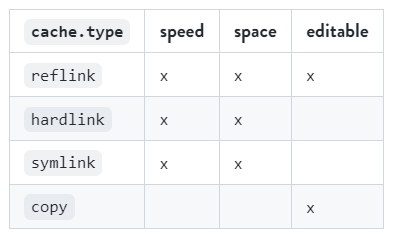

The default strategy is `copy` when you initialize DVC. To change it, you can run:

```
$ dvc config cache.type hardlink[reflink, symlink, copy]
```

### 5. DVC workflow

The general idea of data version control is to include the changes made to large files in your Git commits and branches without hitting Git's size limit. We have mentioned that DVC achieves this by creating small `.dvc` placeholders that change whenever you update DVC-tracked large files. 

So, the basic workflow is this:
1. You start tracking large assets with `dvc add asset_name`.
2. DVC adds the asset to `.gitignore` so it isn't visible to Git while also creating `asset_name.dvc` file.
3. You add this `asset_name.dvc` file to Git with `git add asset_name.dvc`.
4. If you changed other files, say `train.py`, you add that change as well: `git add train.py` or you simply use `git add --all` to capture all changes visible to Git.
5. You make a commit with `git commit -m "Message"`.

This way, you document both your code changes and large asset changes in your Git history. If you switch branches or commits with `git checkout branch_name/commit_hash`, DVC must show you the versions of your large assets for those specific commits or branches. To do this, you must call `dvc checkout` after `git checkout`:

```
$ git checkout branch_name
$ dvc checkout
```


The command will fetch the version of your DVC assets from the cache using the `.dvc` files and the MD5 hashes within.
